In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import utilities as utils
import configuration as config
import matplotlib.pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

#from focal_loss import SparseCategoricalFocalLoss

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Setup and Configuration

In [2]:
# North Carolina
state = 37

# input file
inFile = config.outDir + 'ML_Training_' + str(state) + '.csv'

In [3]:
# read into a Pandas dataframe
df = pd.read_csv( inFile )

# ignore first few columns, which are FIPs codes, not needed for ML
df = df.iloc[:, 3:] 

# building type distributions
print()
print( df['OrnlType'].value_counts() )
print()


Residential         976690
Commercial           64029
Industrial           16722
Assembly              7323
Education             6457
Government            4910
Agriculture           1651
Utility and Misc       362
Name: OrnlType, dtype: int64



In [4]:
976690/df['OrnlType'].value_counts()

Residential            1.000000
Commercial            15.253869
Industrial            58.407487
Assembly             133.372935
Education            151.260647
Government           198.918534
Agriculture          591.574803
Utility and Misc    2698.038674
Name: OrnlType, dtype: float64

## Pre-processing

In [5]:
df.loc[df["OrnlType"] != "Residential", "OrnlType"] = 'Other'

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])


# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

In [7]:
le.inverse_transform([0,1])

array(['Other', 'Residential'], dtype=object)

In [8]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
487030,-1.075439,-0.348103,-0.026605,0.337253,1.051850,0.031186,-0.788243,-0.337799,1.140185,1.278110,0.949244,0.979654,4,1
1003604,0.740532,0.260605,-0.105158,1.302284,0.963812,-0.339621,-1.354833,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
839001,0.906766,0.687815,-0.173168,1.302284,0.963812,-0.339621,0.628233,1.665731,0.880503,0.643556,1.097817,1.041934,4,1
330798,-0.159225,1.268571,-0.155860,-0.937660,-0.273707,0.026131,-0.311114,-0.758292,-0.383523,-0.202516,-0.520841,-0.321399,5,1
348352,-0.111268,1.278203,-0.126456,-0.937660,-0.273707,0.026131,-0.400575,-0.758292,-0.383523,-0.202516,-0.520841,-0.321399,4,1


## Neural Network with focal loss (binary)

In [10]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory

# This is a GPU specific configuration and may not be needed on your GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.compat.v1.Session(config=config)

2023-11-30 10:10:07.760433: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 10:10:07.831288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:10:08.056318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:10:08.056567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [12]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['OrnlType']])

print("shape:", test.shape)

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-1]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-1]
yTrain = train.iloc[:, nCols-1]

Creating test/train split...
shape: (215629, 14)


In [13]:
print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (862513, 13)
Testing Size: (215629, 13)


In [14]:
binary_matrix = np.eye(np.max(yTrain) + 1)[yTrain]

print(binary_matrix)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [15]:
yTrain[0]

1

In [16]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
#y = to_categorical(yTrain)
y = binary_matrix

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0, from_logits=True), 
              optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es])

2023-11-30 10:11:12.342661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:11:12.342847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:11:12.342952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:11:12.343198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 10:11:12.343309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/150


/home/narock/.local/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3370/3370 [==============================] - 17s 4ms/step - loss: 0.0413 - accuracy: 0.9459
Epoch 2/150
3370/3370 [==============================] - 16s 5ms/step - loss: 0.0382 - accuracy: 0.9492
Epoch 3/150
3370/3370 [==============================] - 13s 4ms/step - loss: 0.0377 - accuracy: 0.9499
Epoch 4/150
3370/3370 [==============================] - 15s 4ms/step - loss: 0.0374 - accuracy: 0.9503
Epoch 5/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.0372 - accuracy: 0.9505
Epoch 6/150
3370/3370 [==============================] - 8s 2ms/step - loss: 0.0370 - accuracy: 0.9506
Epoch 7/150
3370/3370 [==============================] - 10s 3ms/step - loss: 0.0368 - accuracy: 0.9507
Epoch 8/150
3370/3370 [==============================] - 13s 4ms/step - loss: 0.0366 - accuracy: 0.9507
Epoch 9/150
3370/3370 [==============================] - 15s 4ms/step - loss: 0.0365 - accuracy: 0.9508
Epoch 10/150
3370/3370 [==============================] - 16s 5ms/step - loss

3370/3370 [==============================] - 16s 5ms/step - loss: 0.0346 - accuracy: 0.9525
Epoch 80/150
3370/3370 [==============================] - 17s 5ms/step - loss: 0.0346 - accuracy: 0.9525
Epoch 81/150
3370/3370 [==============================] - 13s 4ms/step - loss: 0.0346 - accuracy: 0.9525
Epoch 82/150
3370/3370 [==============================] - 15s 5ms/step - loss: 0.0346 - accuracy: 0.9525
Epoch 83/150
3370/3370 [==============================] - 15s 5ms/step - loss: 0.0346 - accuracy: 0.9524
Epoch 84/150
3370/3370 [==============================] - 15s 5ms/step - loss: 0.0346 - accuracy: 0.9524
Epoch 85/150
3370/3370 [==============================] - 15s 4ms/step - loss: 0.0346 - accuracy: 0.9524
Epoch 86/150
3370/3370 [==============================] - 15s 4ms/step - loss: 0.0346 - accuracy: 0.9525
Epoch 87/150
3370/3370 [==============================] - 16s 5ms/step - loss: 0.0345 - accuracy: 0.9525
Epoch 88/150
3370/3370 [==============================] - 16s 5ms/st

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                420       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 2)                 32        
                                                                 
Total params: 917
Trainable params: 917
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Epoch')

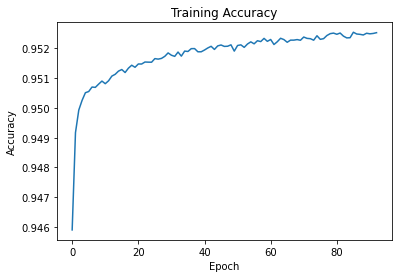

In [18]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [19]:
model.save_weights("./focal_loss_binary_model.h5")

In [20]:
#y = to_categorical(yTest)
y = np.eye(np.max(yTest) + 1)[yTest]

loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

  97/6739 [..............................] - ETA: 6s - loss: 0.0377 - accuracy: 0.9491 

/home/narock/.local/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6739/6739 [==============================] - 7s 974us/step - loss: 0.0352 - accuracy: 0.9524
Accuracy on the test set: 0.9524


In [21]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

215629

In [25]:
from sklearn.metrics import precision_score, recall_score

testy = yTest.values

print( "Balanced Accuracy:", np.round( balanced_accuracy_score(testy, predictions), 4 ) )
print( "Macro F1:", np.round( f1_score(testy, predictions, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(testy, predictions, average='macro'), 2 ) )
print( "Macro Recall:", np.round( recall_score(testy, predictions, average='macro'), 2 ) )

Balanced Accuracy: 0.8086
Macro F1: 0.8439
Macro Precision: 0.89
Macro Recall: 0.81


In [26]:
cm = confusion_matrix( testy, predictions, normalize='true' )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


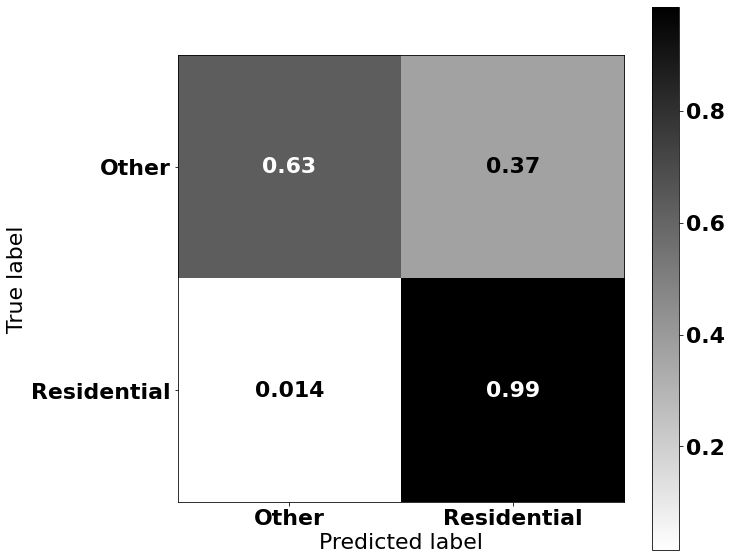

In [27]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

## Neural Network for multiclass classification - 3 classes

In [34]:
# read into a Pandas dataframe
df = pd.read_csv( inFile )

# ignore first few columns, which are FIPs codes, not needed for ML
df = df.iloc[:, 3:] 

# building type distributions
print()
print( df['OrnlType'].value_counts() )
print()


Residential         976690
Commercial           64029
Industrial           16722
Assembly              7323
Education             6457
Government            4910
Agriculture           1651
Utility and Misc       362
Name: OrnlType, dtype: int64



In [35]:
df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# change the rows we don't need
df.loc[df["OrnlType"] == "Industrial", "OrnlType"] = 'Other'
df.loc[df["OrnlType"] == "Assembly", "OrnlType"] = 'Other'
df.loc[df["OrnlType"] == "Education", "OrnlType"] = 'Other'
df.loc[df["OrnlType"] == "Government", "OrnlType"] = 'Other'
df.loc[df["OrnlType"] == "Agriculture", "OrnlType"] = 'Other'
df.loc[df["OrnlType"] == "Utility and Misc", "OrnlType"] = 'Other'

df['OrnlType'].value_counts()

Residential    976690
Commercial      64029
Other           37425
Name: OrnlType, dtype: int64

In [36]:
# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])


# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

In [37]:
le.inverse_transform([0,1,2])

array(['Commercial', 'Other', 'Residential'], dtype=object)

In [38]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['OrnlType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-1]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-1]
yTrain = train.iloc[:, nCols-1]

print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)
print( np.unique(df.OrnlType) )

Creating test/train split...
Training Size: (862513, 13)
Testing Size: (215629, 13)
[0 1 2]


In [39]:
np.unique(df.OrnlType)

array([0, 1, 2])

In [40]:
"""
Define our custom loss function.
"""
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.

      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)

      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.

    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)

    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return binary_focal_loss_fixed


def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1

      where m = number of classes, c = class and o = observation

    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)

    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper

    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy

    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed


if __name__ == '__main__':

    # Test serialization of nested functions
    bin_inner = dill.loads(dill.dumps(binary_focal_loss(gamma=2., alpha=.25)))
    print(bin_inner)

    cat_inner = dill.loads(dill.dumps(categorical_focal_loss(gamma=2., alpha=.25)))
    print(cat_inner)


<function binary_focal_loss.<locals>.binary_focal_loss_fixed at 0x7f80f9bf5360>
<function categorical_focal_loss.<locals>.categorical_focal_loss_fixed at 0x7f80f8fb7910>


In [44]:
tf.keras.backend.clear_session()

In [45]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
#y = to_categorical(yTrain)
y = np.eye(np.max(yTrain) + 1)[yTrain]


# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], 
              optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es])

Epoch 1/150
3370/3370 [==============================] - 12s 4ms/step - loss: 0.0232 - accuracy: 0.9285
Epoch 2/150
3370/3370 [==============================] - 14s 4ms/step - loss: 0.0215 - accuracy: 0.9316
Epoch 3/150
3370/3370 [==============================] - 14s 4ms/step - loss: 0.0213 - accuracy: 0.9323
Epoch 4/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.0211 - accuracy: 0.9327
Epoch 5/150
3370/3370 [==============================] - 10s 3ms/step - loss: 0.0210 - accuracy: 0.9332
Epoch 6/150
3370/3370 [==============================] - 12s 3ms/step - loss: 0.0209 - accuracy: 0.9333
Epoch 7/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.0208 - accuracy: 0.9334
Epoch 8/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.0207 - accuracy: 0.9335
Epoch 9/150
3370/3370 [==============================] - 10s 3ms/step - loss: 0.0206 - accuracy: 0.9336
Epoch 10/150
3370/3370 [==============================] - 13s 4m

Text(0.5, 0, 'Epoch')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


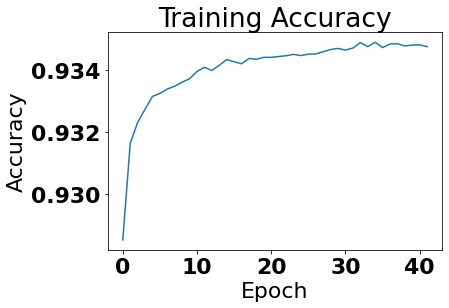

In [46]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [47]:
#y = to_categorical(yTest)
y = np.eye(np.max(yTest) + 1)[yTest]

loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6739/6739 [==============================] - 6s 884us/step - loss: 0.0200 - accuracy: 0.9348
Accuracy on the test set: 0.9348


In [48]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

215629

In [50]:
testy = yTest.values

print( "Balanced Accuracy:", np.round( balanced_accuracy_score(testy, predictions), 4 ) )
print( "Macro F1:", np.round( f1_score(testy, predictions, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(testy, predictions, average='macro'), 2 ) )
print( "Macro Recall:", np.round( recall_score(testy, predictions, average='macro'), 2 ) )

Balanced Accuracy: 0.5788
Macro F1: 0.6193
Macro Precision: 0.71
Macro Recall: 0.58
